In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pygrib
import metpy.calc as mcalc
from metpy.units import units
import pygrib
import metpy

In [3]:
import sys
sys.path.append("/home/takato/Git/jma_radar/")
import jma_gsm
import custom_colormap
cmap=custom_colormap.get_jmacmap2()

In [8]:
import importlib
importlib.reload(jma_gsm)

<module 'jma_gsm' from '/home/takato/Git/jma_radar/jma_gsm.py'>

In [9]:
levels=[1000,925,850,700,600,500,400,300]

In [10]:
file="/home/takato/Data/JMA/GSM/Z__C_RJTD_20210814000000_GSM_GPV_Rgl_FD0012_grib2.bin"
gsm=jma_gsm.GSM_global()
ds_sfc=gsm.read_sfc(file,product_type="FCT")
ds_lev=gsm.read_plev(file)

In [12]:
jma_gsm.GSM_global.add_dew_point_depreession_equ_potential_T(ds_lev)
jma_gsm.GSM_global.add_wind_vorticity_omega(ds_lev)

/home/takato/miniconda3/envs/jupyterlab-debugger/lib/python3.9/site-packages/pint/numpy_func.py:303: RuntimeWarning: divide by zero encountered in log
  result_magnitude = func(*stripped_args, **stripped_kwargs)
/home/takato/miniconda3/envs/jupyterlab-debugger/lib/python3.9/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


In [13]:
ds_lev

<xarray.Dataset>
Dimensions:  (lat: 141, level: 9, lon: 301)
Coordinates:
  * level    (level) int64 1000 925 850 700 500 300 250 200 150
  * lat      (lat) float64 70.0 69.5 69.0 68.5 68.0 67.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float64 60.0 60.5 61.0 61.5 62.0 ... 208.5 209.0 209.5 210.0
Data variables:
    hgt      (level, lat, lon) float64 -70.1 -69.1 -67.6 ... 1.422e+04 1.422e+04
    u        (level, lat, lon) float64 1.809 2.074 2.215 ... -0.3021 -0.1771
    v        (level, lat, lon) float64 3.936 4.139 4.17 ... -0.7854 -0.5041
    T        (level, lat, lon) float64 289.1 290.3 290.6 ... 205.4 205.3 205.3
    w        (level, lat, lon) float64 0.0108 0.03424 ... -0.01251 -0.007632
    rh       (level, lat, lon) float64 96.66 90.72 87.32 86.29 ... 0.0 0.0 0.0
    Tw       (level, lat, lon) float64 288.6 288.7 288.5 288.2 ... nan nan nan
    T-Tw     (level, lat, lon) float64 0.5303 1.528 2.129 2.312 ... nan nan nan
    theta_w  (lat, lon) float64 <Quantity([[319.55630904 319.1842259  318.706...
    vo       (level, lat, lon) float64 <Quantity([[[-5.59029072e-06 -2.075482...
    wind     (level, lat, lon) float64 4.331 4.629 4.722 ... 1.033 0.8414 0.5343
    vp       (level, lat, lon) float64 0.3887 1.232 1.232 ... -0.4505 -0.2748

## データの読み込み

In [5]:
gsm=pygrib.open("/home/takato/Data/JMA/GSM/Z__C_RJTD_20210801000000_GSM_GPV_Rgl_FD0012_grib2.bin")

In [6]:
gsm.rewind()

In [7]:
for i in gsm:
    print(i)

1:Pressure reduced to MSL:Pa (instant):regular_ll:meanSea:level 0:fcst time 12 hrs:from 202108010000
2:Surface pressure:Pa (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 202108010000
3:10 metre U wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 12 hrs:from 202108010000
4:10 metre V wind component:m s**-1 (instant):regular_ll:heightAboveGround:level 10 m:fcst time 12 hrs:from 202108010000
5:2 metre temperature:K (instant):regular_ll:heightAboveGround:level 2 m:fcst time 12 hrs:from 202108010000
6:2 metre relative humidity:% (instant):regular_ll:heightAboveGround:level 2 m:fcst time 12 hrs:from 202108010000
7:Low cloud cover:% (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 202108010000
8:Medium cloud cover:% (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 202108010000
9:High cloud cover:% (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 202108010000
10:Total cloud cover:% (instant):regular_ll:surface:level 0:f

In [8]:
Tval=np.zeros((len(levels),361,720),dtype="float32")
hgtval=np.zeros_like(Tval)
rhval=np.zeros_like(Tval)
uwind=np.zeros_like(Tval)
vwind=np.zeros_like(Tval)

In [9]:
for i,lev in enumerate(levels):
    print(lev)
    T=gsm.select(parameterName="Temperature",level=lev)[0]
    hgt=gsm.select(name="Geopotential Height",level=lev)[0]
    rh=gsm.select(parameterName="Relative humidity",level=lev)[0]
    u=gsm.select(name="U component of wind",level=lev)[0]
    v=gsm.select(name="V component of wind",level=lev)[0]
    Tval[i,:,:]=T.values
    hgtval[i,:,:]=hgt.values
    rhval[i,:,:]=rh.values
    uwind[i,:,:]=u.values
    vwind[i,:,:]=v.values
wind=np.sqrt(uwind**2+vwind**2)
wind=wind/0.5144 # m/s=>kt

1000
925
850
700
600
500
400
300


In [10]:
lat,lon=T.latlons()
lat=lat[:,0]
lon=lon[0,:]

In [11]:
#露点温度の算出
Tair=units.Quantity(Tval,"K")
RH=units.Quantity(rhval,"%")
Tw=mcalc.dewpoint_from_relative_humidity(Tair,RH)
Twval=Tair - (Tw)

In [12]:
values={"T":(["level","lat","lon"],Tval-273.15,{"title":"temperature","units":"degree_celsius"}),
        "hgt":(["level","lat","lon"],hgtval,{"title":"geopotential height","units":"gpm"}),
        "rh":(["level","lat","lon"],rhval,{"title":"relative humidity","units":"%"}),
        "Tw":(["level","lat","lon"],Twval,{"title":"dew point depression","units":"degree_celsius"}),
        "wind":(["level","lat","lon"],wind,{"title":"wind speed","units":"kt"}),
        "u":(["level","lat","lon"],uwind,{"title":"u wind","units":"m/s"}),
        "v":(["level","lat","lon"],vwind,{"title":"v wind","units":"m/s"})
       }
coords={
    "level":levels,
    "lat":(("lat",lat,{"units":"degrees_north"})),
    "lon":(("lon",lon,{"units":"degrees_east"}))
}

ds=xr.Dataset(values,coords)
ds2=ds.sel(lat=slice(70,0),lon=slice(60,210))

In [13]:
encoding={
    "T":{"zlib":True,"dtype":"float32"},
    "hgt":{"zlib":True,"dtype":"float32"},
    "rh":{"zlib":True,"dtype":"float32"},
    "Tw":{"zlib":True,"dtype":"float32"},
    "wind":{"zlib":True,"dtype":"float32"},
    "u":{"zlib":True,"dtype":"float32"},
    "v":{"zlib":True,"dtype":"float32"},
}
ds2=ds.sel(lat=slice(70,0),lon=slice(60,210))
ds2.to_netcdf("./sample.nc",encoding=encoding)

## 850hPa高層天気図
1500mを基準高度　60mごとに実線、120mごとに値を表示、300mごとに太実線で表記
等温線は4～9月は3℃ごと、10~3月は6℃ごとの表記
湿数が3℃未満の湿り域をドットで表記

Text(0.5, 1.0, '850hPa')

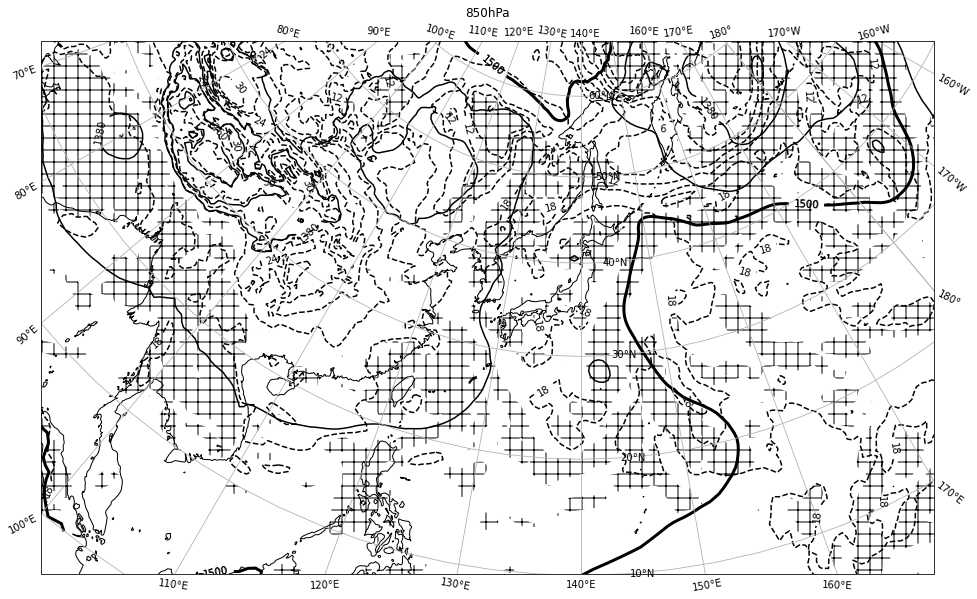

In [19]:
time=230
level=850
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
# ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#等高度線
base=1500
cs=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree()
              ,levels=np.arange(base-60*10,base+60*10,60),colors="k")
cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree()
               ,levels=np.arange(base-60*10,base+60*10,300),colors="k",linewidths=3)

ax.clabel(cs,cs.levels[::2])
ax.clabel(cs2,[1500])

#等温線
baseT=0
cs3=ax.contour(ds2["lon"], ds2["lat"], ds2["T"].sel(level=level),transform=ccrs.PlateCarree()
            ,levels=np.arange(baseT-6*10,baseT+6*6,3),colors="k"
            ,linestyles="dashed")
ax.clabel(cs3,cs3.levels[::2])

# 湿り域
cs4=ax.contourf(ds2["lon"],ds2["lat"],ds2["Tw"].sel(level=level),transform=ccrs.PlateCarree(),levels=[-273.15,3],hatches=[".."],colors=None,alpha=0)


ax.set_title("850hPa")

# ax.contourf(dsair["lon"],dsair["lat"],dshgt["hgt"].isel(time=time,level=2),transform=ccrs.PlateCarree(),cmap="bwr"
#             ,levels=np.arange(base-60*10,base+60*10,60))

## 700hPa高層天気図

Text(0.5, 1.0, '700hPa')

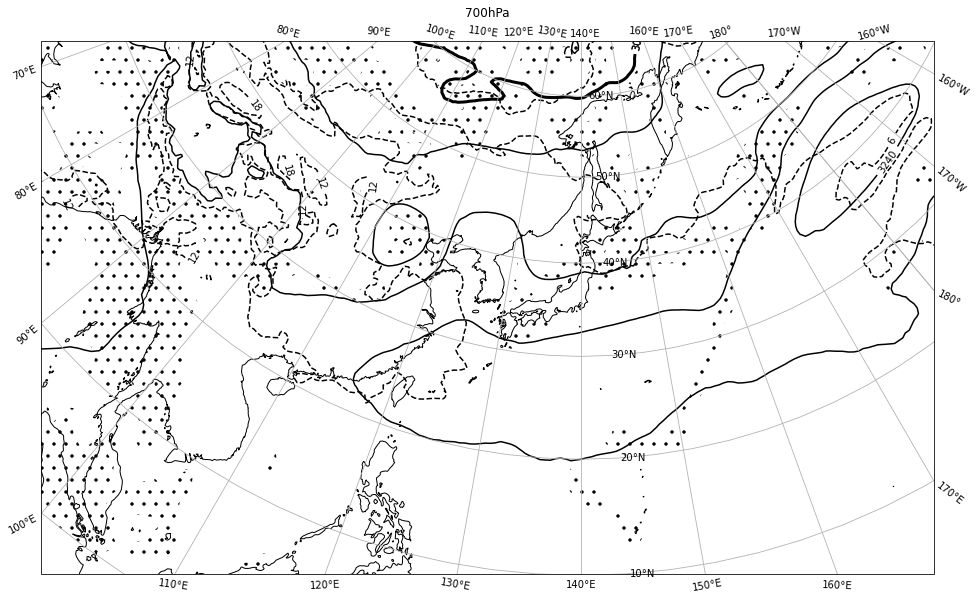

In [14]:
time=230
level=700
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#等高度線
levles=np.arange(base-60*10,base+60*10,60)
base=3000
cs=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree()
              ,levels=np.arange(base-60*10,base+60*10,60),colors="k")
cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree()
               ,levels=np.arange(base-60*10,base+60*10,300),colors="k",linewidths=3)

ax.clabel(cs,cs.levels[::2])
ax.clabel(cs2,[base])

#等温線
baseT=0
cs3=ax.contour(ds2["lon"], ds2["lat"], ds2["T"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(baseT-6*10,baseT+6*6,6),colors="k",
              linestyles="dashed")
ax.clabel(cs3,cs3.levels)

# 湿り域
cs4=ax.contourf(ds2["lon"],ds2["lat"],ds2["Tw"].sel(level=level),transform=ccrs.PlateCarree(),levels=[-273.15,3],hatches=[".."],colors=None,alpha=0)


ax.set_title("700hPa")

## 500hPa高層天気図

Text(0.5, 1.0, '500hPa')

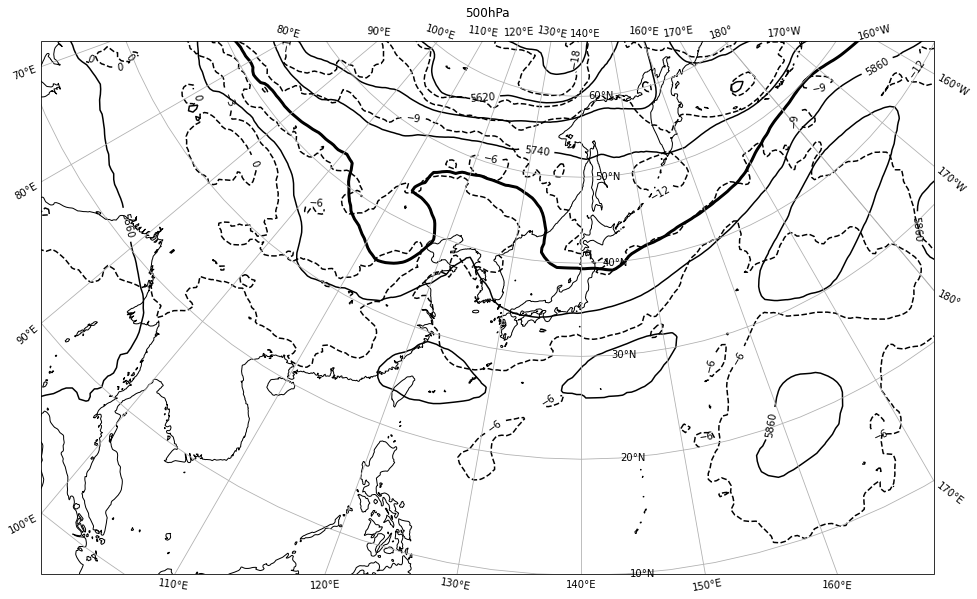

In [15]:
time=230
level=500
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#等高度線
levles=np.arange(base-60*10,base+60*10,60)
base=5500
cs=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,60),colors="k")
cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,300),colors="k",linewidths=3)

ax.clabel(cs,cs.levels[::2])
ax.clabel(cs2,[base])

#等温線
baseT=0
cs3=ax.contour(ds2["lon"], ds2["lat"], ds2["T"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(baseT-6*10,baseT+6*6,3),colors="k",
              linestyles="dashed")
ax.clabel(cs3,cs3.levels)


ax.set_title("500hPa")

## 300hPa高層天気図

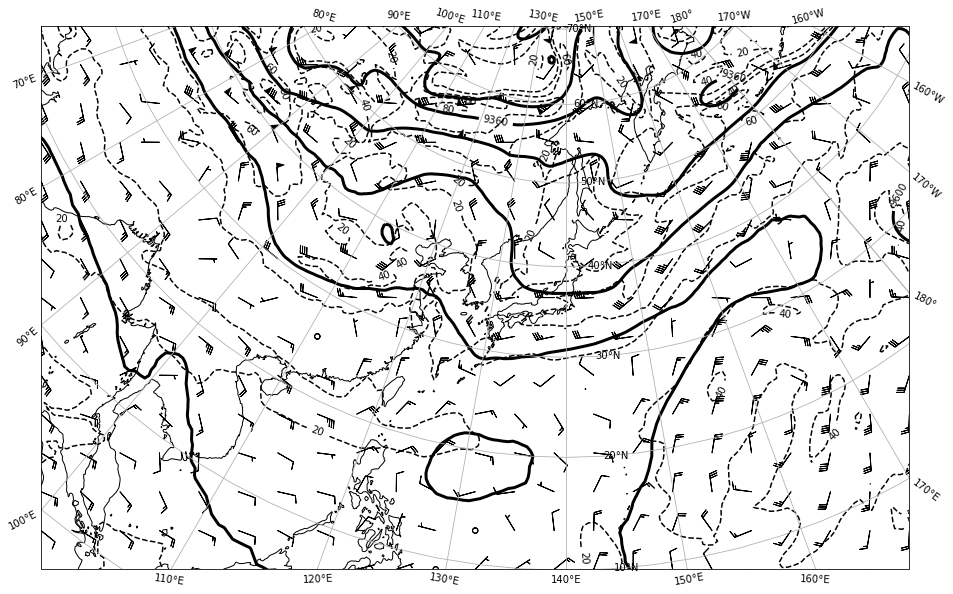

In [16]:
time=230
level=300
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,60],crs=ccrs.PlateCarree())
#等高度線
levles=np.arange(base-60*10,base+60*10,60)
base=9600
cs=ax.contour(ds["lon"],ds["lat"],ds["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-120*10,base+120*10,120),colors="k",linewidths=3)

ax.clabel(cs,cs.levels[::2])
#ax.clabel(cs2,[base])

#等風速線
basewind=20
cs3=ax.contour(ds["lon"], ds["lat"], ds["wind"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(0,100.1,20),colors="k",
              linestyles="dashed")
ax.clabel(cs3,cs3.levels)
# 矢羽根プロット
ax.barbs(ds["lon"],ds["lat"],ds["u"].sel(level=level).values/0.51,ds["v"].sel(level=level).values/0.51
        ,length=6,regrid_shape=15,transform=ccrs.PlateCarree())

#
basewind=20
# cs4=ax.contourf(ds["lon"], ds["lat"], ds["T"].sel(level=level),transform=ccrs.PlateCarree(),cmap="bwr"
#                ,levels=np.arange(210,255,2))
#ax.clabel(cs4,cs3.levels)

# 数値予報図

## 500hPa高度・渦度図

In [17]:
ds2["vor"]=mcalc.vorticity(ds2["u"],ds2["v"])

Text(0.5, 1.0, '500hPa')

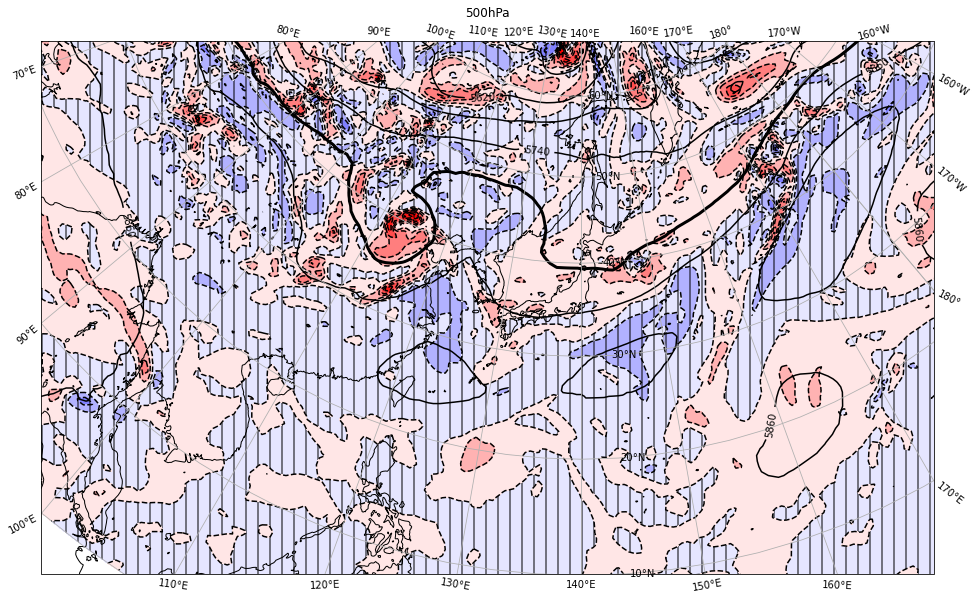

In [21]:
time=230
level=500
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#等高度線
base=5500
cs=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,60),colors="k")
cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,300),colors="k",linewidths=3)

ax.clabel(cs,cs.levels[::2])
ax.clabel(cs2,[base])

#等温線
baseT=0
hatches=["|"]*6+[None]*5
volevels=np.arange(-200,200.1,40)
cs3=ax.contourf(ds2["lon"],ds2["lat"],ds2["vor"].sel(level=level)*1e6
               ,transform=ccrs.PlateCarree()
               ,levels=volevels,cmap="bwr",hatches=hatches,extend="both")
cs3=ax.contour(ds2["lon"],ds2["lat"],ds2["vor"].sel(level=level)*1e6
               ,transform=ccrs.PlateCarree()
               ,levels=volevels,colors="k",extend="both",linestyles="dashed")

ax.set_title("500hPa")

## 地上気圧、降水量、風予想図

In [38]:
gsm_sfc=pygrib.open("/home/takato/Data/JMA/GSM/Z__C_RJTD_20210815000000_GSM_GPV_Rgl_FD0012_grib2.bin")

In [102]:

pmsl_val=np.zeros((361,720))
precip_val=np.zeros_like(pmsl_val)
uwind=np.zeros_like(pmsl_val)
vwind=np.zeros_like(pmsl_val)

pmsl=gsm.select(name="Pressure reduced to MSL")[0]
# rh=gsm_sfc.select(parameterName="Relative humidity",level=0)[0]
u=gsm_sfc.select(name="10 metre U wind component")[0]
v=gsm_sfc.select(name="10 metre V wind component")[0]
precip=gsm_sfc.select(parameterName="Total precipitation",level=0)[0]

pmsl_val[:,:]=pmsl.values
# rhval[:,:]=rh.values
uwind[:,:]=u.values
vwind[:,:]=v.values
wind=np.sqrt(uwind**2+vwind**2)
wind=wind/0.5144 # m/s=>kt
precip_val=precip.values

ValueError: no matches found

In [104]:
pmsl=gsm.select(name="Pressure reduced to MSL")
pmsl

[1:Pressure reduced to MSL:Pa (instant):regular_ll:meanSea:level 0:fcst time 0 hrs:from 202107120000]

In [64]:
values={
        "pmsl":(["lat","lon"],pmsl_val,{"title":"mean suface level pressure","units":"Pa"}),
        "precip":(["lat","lon"],precip_val,{"title":"dew point depression","units":"degree_celsius"}),
        "wind":(["lat","lon"],wind,{"title":"wind speed","units":"kt"}),
        "u":(["lat","lon"],uwind,{"title":"u wind","units":"m/s"}),
        "v":(["lat","lon"],vwind,{"title":"v wind","units":"m/s"})
       }
coords={

    "lat":(("lat",lat,{"units":"degrees_north"})),
    "lon":(("lon",lon,{"units":"degrees_east"}))
}

ds=xr.Dataset(values,coords)
ds2=ds.sel(lat=slice(70,0),lon=slice(60,210))

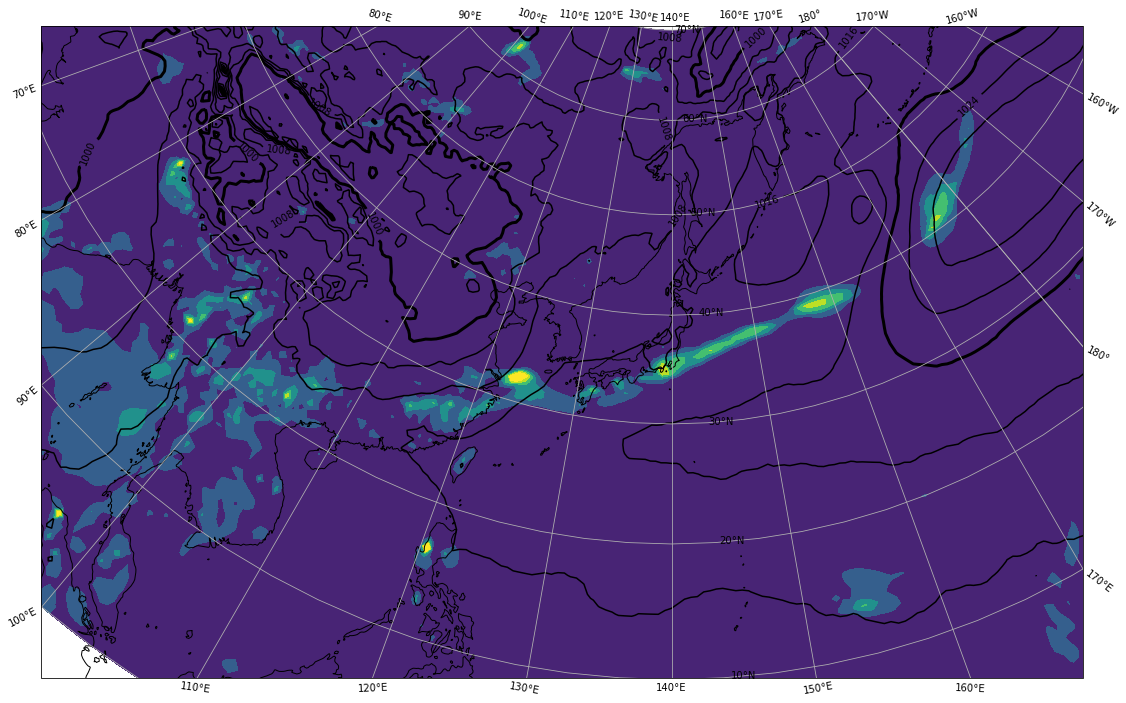

In [90]:
fig=plt.figure(figsize=(20,12))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,60],crs=ccrs.PlateCarree())
#等圧線
base=1000
levels1=np.arange(base-4*30,base+4*25,4).tolist()
labeled_levels1=levels1[::2].copy()
labeled_levels2=[]
levels2=[880,900,920,940,960,980,1000,1020,1040]
for i in levels2:
    levels1.remove(i)
    if i in labeled_levels1:
        labeled_levels1.remove(i)
        labeled_levels2.append(i)
cs=ax.contour(ds2["lon"],ds2["lat"],ds2["pmsl"]*1e-2,transform=ccrs.PlateCarree()
              ,levels=levels1,colors="k")
cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["pmsl"]*1e-2,transform=ccrs.PlateCarree()
               ,levels=levels2,colors="k",linewidths=3)
ax.clabel(cs,labeled_levels1)
ax.clabel(cs2,labeled_levels2)

#等風速線
basewind=20
# 矢羽根プロット
ax.barbs(ds2["lon"],ds2["lat"],ds2["u"].values/0.51,ds2["v"].values/0.51
        ,length=6,regrid_shape=15,transform=ccrs.PlateCarree())

#等降水量線
cs3=ax.contourf(ds2["lon"],ds2["lat"],ds2["precip"],transform=ccrs.PlateCarree(),
              levels=np.arange(0,50.1,10),extend="max",linestyles="dashed")



#
basewind=20

In [29]:
ds_lev["vp"]=ds_lev["w"]*1e-2*3600e0
ds_lev

<xarray.Dataset>
Dimensions:  (lat: 141, level: 9, lon: 301)
Coordinates:
  * level    (level) int64 1000 925 850 700 500 300 250 200 150
  * lat      (lat) float64 70.0 69.5 69.0 68.5 68.0 67.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float64 60.0 60.5 61.0 61.5 62.0 ... 208.5 209.0 209.5 210.0
Data variables:
    hgt      (level, lat, lon) float64 -70.1 -69.1 -67.6 ... 1.422e+04 1.422e+04
    u        (level, lat, lon) float64 1.809 2.074 2.215 ... -0.3021 -0.1771
    v        (level, lat, lon) float64 3.936 4.139 4.17 ... -0.7854 -0.5041
    T        (level, lat, lon) float64 289.1 290.3 290.6 ... 205.4 205.3 205.3
    w        (level, lat, lon) float64 0.0108 0.03424 ... -0.01251 -0.007632
    rh       (level, lat, lon) float64 96.66 90.72 87.32 86.29 ... 0.0 0.0 0.0
    Tw       (level, lat, lon) float64 288.6 288.7 288.5 288.2 ... nan nan nan
    T-Tw     (level, lat, lon) float64 0.5303 1.528 2.129 2.312 ... nan nan nan
    theta_w  (lat, lon) float64 <Quantity([[319.55630904 319.1842259  318.706...
    vo       (level, lat, lon) float64 <Quantity([[[-5.59029072e-06 -2.075482...
    wind     (level, lat, lon) float64 4.331 4.629 4.722 ... 1.033 0.8414 0.5343
    vp       (level, lat, lon) float64 0.3887 1.232 1.232 ... -0.4505 -0.2748

## 850hPa気温風,700hPa上昇流図

Text(0.5, 1.0, '500hPa')

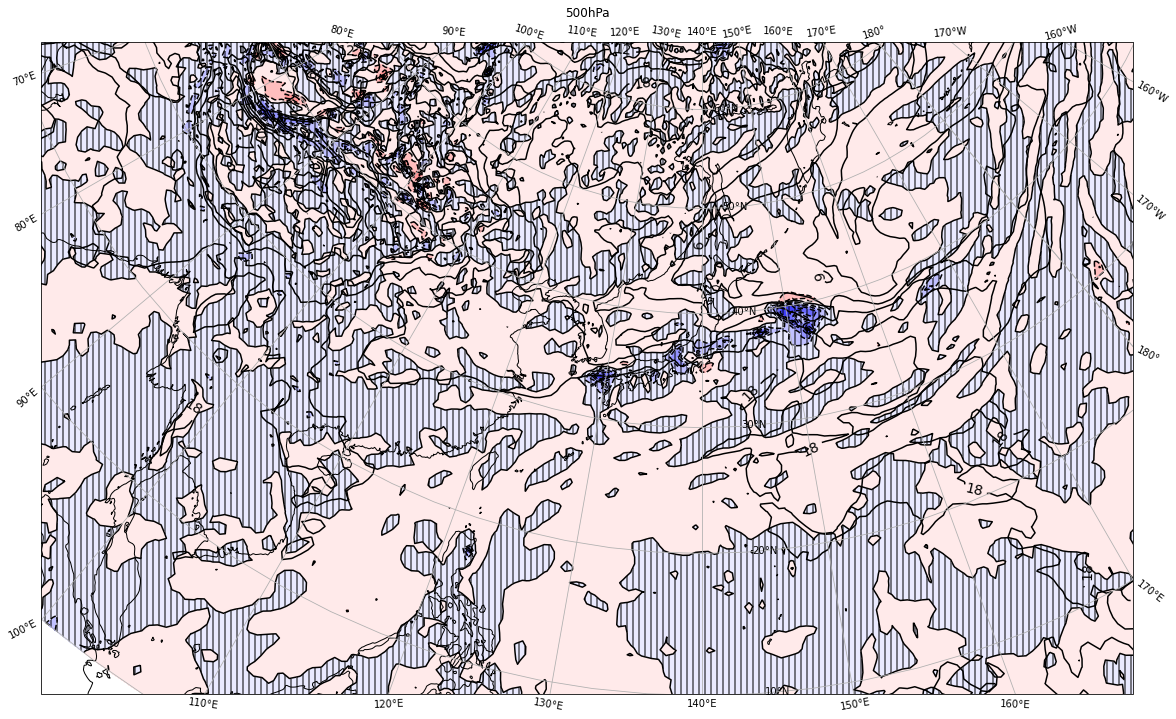

In [36]:
fig=plt.figure(figsize=(20,12))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
#ax.set_extent([120,150,20,50],crs=ccrs.PlateCarree())
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#等高度線
# base=5500
# cs=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,60),colors="k")
# cs2=ax.contour(ds2["lon"],ds2["lat"],ds2["hgt"].sel(level=level),transform=ccrs.PlateCarree(),levels=np.arange(base-60*10,base+60*10,300),colors="k",linewidths=3)

# ax.clabel(cs,cs.levels[::2])
# ax.clabel(cs2,[base])


baseT=0

#850hPa等温線
Tlevels=np.arange(-60,40,3)
cs3=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["T"].sel(level=850)-273.15
               ,transform=ccrs.PlateCarree(),colors="k"
               ,levels=Tlevels)
ax.clabel(cs3,cs3.levels[::2],fontsize=14)
#850hPa風
# 矢羽根プロット
ax.barbs(ds_lev["lon"],ds_lev["lat"],ds_lev["u"].sel(level=850).values/0.51,ds_lev["v"].sel(level=850).values/0.51
        ,length=6,regrid_shape=12,transform=ccrs.PlateCarree())

hatches=["||"]*6+[None]*7
linestyles=["dashed"]*6+["solid"]+["dashed"]*6

#700hPa鉛直p速度
cs4=ax.contourf(ds_lev["lon"],ds_lev["lat"],ds_lev["vp"].sel(level=700)
               ,transform=ccrs.PlateCarree(),cmap="bwr"
               ,levels=np.arange(-120,121,20),hatches=hatches,linestyles=linestyles)
cs4_2=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["vp"].sel(level=700)
               ,transform=ccrs.PlateCarree(),colors="k"#cmap="bwr"
               ,levels=np.arange(-120,121,20),linestyles=linestyles)
#ax.clabel(cs4,cs4.levels[::2])

ax.set_title("500hPa")

## 500hPa気温・700hPa湿数予想図

Text(0.5, 1.0, '500hPa')

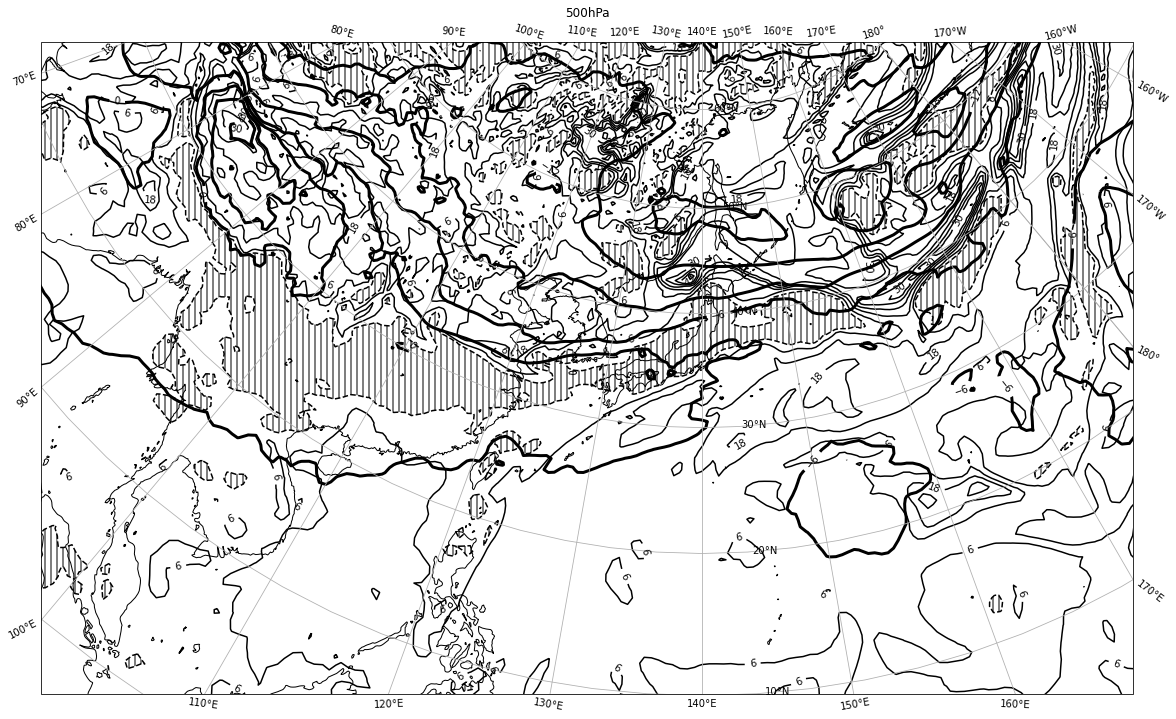

In [37]:
fig=plt.figure(figsize=(20,12))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
ax.set_extent([90,170,10,55],crs=ccrs.PlateCarree())
#500hPa等温線
Tlevels=np.arange(-60,40,3)
cs3=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["T"].sel(level=500)-273.15
               ,transform=ccrs.PlateCarree(),colors="k",linewidths=3,linestyles="solid"
               ,levels=Tlevels)
ax.clabel(cs3,cs3.levels[::2])
#700hPa湿数
#700hPa鉛直p速度
x=[0,3,6,12,18,24,30,36,42,48,54,60,66,72,78,84,90,96,102]
h=["||"]*1+[None]*17
l=["dashed"]*2+["solid"]*16
cs4=ax.contourf(ds_lev["lon"],ds_lev["lat"],ds_lev["T-Tw"].sel(level=700)
               ,transform=ccrs.PlateCarree(),colors="none"
               ,levels=x,hatches=h)

cs4_2=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["T-Tw"].sel(level=700)
               ,transform=ccrs.PlateCarree(),colors="k"
               ,levels=x,linestyles=l)

ax.clabel(cs4_2,cs4_2.levels[2::2])

ax.set_title("500hPa")

## 850hPa風・相当温位予想図

<a list of 70 text.Text objects>

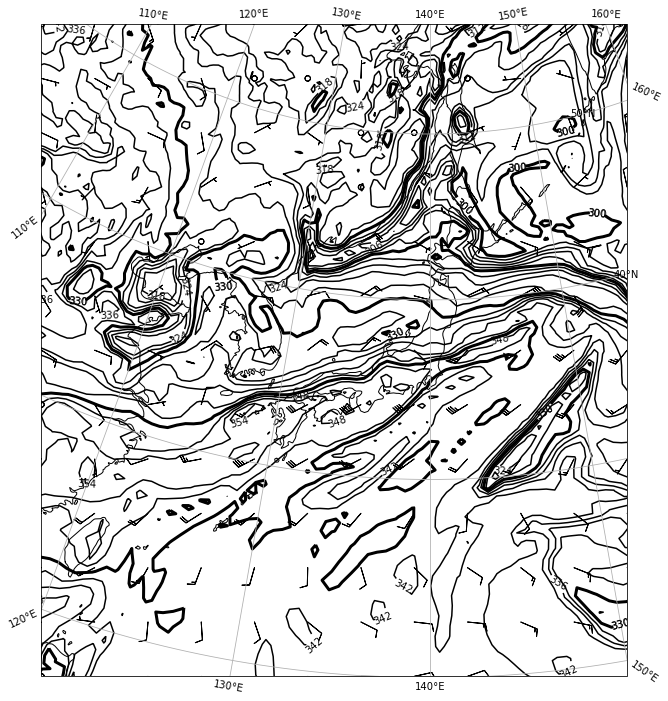

In [26]:
fig=plt.figure(figsize=(20,12))
ax=fig.add_subplot(1,1,1,projection=ccrs.NorthPolarStereo(central_longitude=140))
ax.gridlines(draw_labels=True,xlocs=plt.MultipleLocator(10),ylocs=plt.MultipleLocator(10))
ax.coastlines(resolution="50m")
ax.set_extent([120,150,20,55],crs=ccrs.PlateCarree())

#850hPa風矢羽根プロット
ax.barbs(ds_lev["lon"],ds_lev["lat"],ds_lev["u"].sel(level=850).values/0.51,ds_lev["v"].sel(level=850).values/0.51
        ,length=6,regrid_shape=12,transform=ccrs.PlateCarree())
#850hPa相当温位線
theta_levels=np.arange(300-90,300+90,3)
cs4=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["theta_w"]
               ,transform=ccrs.PlateCarree(),colors="k"
               ,levels=theta_levels)
cs4_2=ax.contour(ds_lev["lon"],ds_lev["lat"],ds_lev["theta_w"]
               ,transform=ccrs.PlateCarree(),colors="k"
               ,levels=theta_levels[::5],linewidths=3)

ax.clabel(cs4,cs4.levels[::2])
ax.clabel(cs4_2,[210,240,270,300,330,360])

In [14]:
vp=ds_lev["vp"].sel(level=700).values
vp

array([[ 4.05683899,  2.65058899,  0.25996399, ...,  2.08808899,
         1.94746399, -0.30253601],
       [ 1.66621399,  4.61933899,  4.47871399, ...,  1.52558899,
         1.80683899,  0.40058899],
       [-9.16191101, -5.50566101, -6.34941101, ...,  2.36933899,
         1.66621399, -0.02128601],
       ...,
       [ 1.80683899,  0.96308899, -0.02128601, ...,  3.21308899,
         1.94746399,  0.40058899],
       [-0.44316101, -0.72441101, -1.14628601, ...,  3.91621399,
         2.36933899,  2.22871399],
       [-1.42753601, -1.42753601, -1.70878601, ...,  5.32246399,
         4.61933899,  4.05683899]])

In [16]:
from scipy.ndimage.filters import maximum_filter

In [68]:
def detect_peaks_precip(ds, filter_size=3, order=0.3):
    lon=ds["lon"].values
    lat=ds["lat"].values
    precip=ds["precip"].values
    local_max = maximum_filter(precip, footprint=np.ones((filter_size, filter_size)), mode='constant')
    detected_peaks = np.ma.array(precip, mask=~(precip == local_max))
    # 小さいピーク値を排除（最大ピーク値のorder倍のピークは排除）
    peak_values = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
    peaks_index = np.where((peak_values.mask != True))
    df_peak=pd.DataFrame(data={"x":peaks_index[1][:], "y":peaks_index[0][:]})
    
    for idx,(x,y) in enumerate(zip(df_peak["x"],df_peak["y"])):
        df_peak.loc[idx,"value"]=precip[y,x]
    df_peak["label"]=[str(int(x)) for x in df_peak["value"]]
    df_peak["lon"]=[lon[x] for x in df_peak["x"]]
    df_peak["lat"]=[lat[y] for y in df_peak["y"]]
    return df_peak

def plot_peak(ax,df_peak):
    
    #y方向で距離が近い点を間引く
    peak_list=[]
    prev_x,prev_y=None,None
    for idx,(x,y) in enumerate(zip(df_peak["x"],df_peak["y"])):
        if (prev_x is not None ):
            r=np.sqrt((x-prev_x)**2 + (y-prev_y)**2)
            if r < 5:
                continue
        prev_x,prev_y=x,y
        peak_list.append(idx)
        
    #x方向で距離が近い点を間引く
    peak_list2=[]    
    df_peak_sort=df_peak.loc[peak_list].sort_values("x")
    prev_x,prev_y=None,None
    for (idx,x,y) in zip(df_peak_sort.index,df_peak_sort["x"],df_peak_sort["y"]):
        if (prev_x is not None):
            r=np.sqrt((x-prev_x)**2 + (y-prev_y)**2)
            if r < 5:
                continue
        prev_x,prev_y=x,y
        peak_list2.append(idx)
    #プロットする
    for lon,lat,label in zip(df_peak_sort.loc[peak_list2,"lon"], df_peak_sort.loc[peak_list2,"lat"],df_peak_sort.loc[peak_list2,"label"]):
        ax.scatter(lon, lat, color='black',transform=ccrs.PlateCarree(),marker="+",s=100)
        ax.text(lon, lat, "\n"+label, verticalalignment="center", horizontalalignment="center",transform=ccrs.PlateCarree(),fontsize=14)

In [86]:
importlib.reload(jma_gsm)

<module 'jma_gsm' from '/home/takato/Git/jma_radar/jma_gsm.py'>

In [87]:
df_peak=detect_peaks_precip(ds_sfc)

In [88]:
wmap=jma_gsm.Wheather_map()
wmap

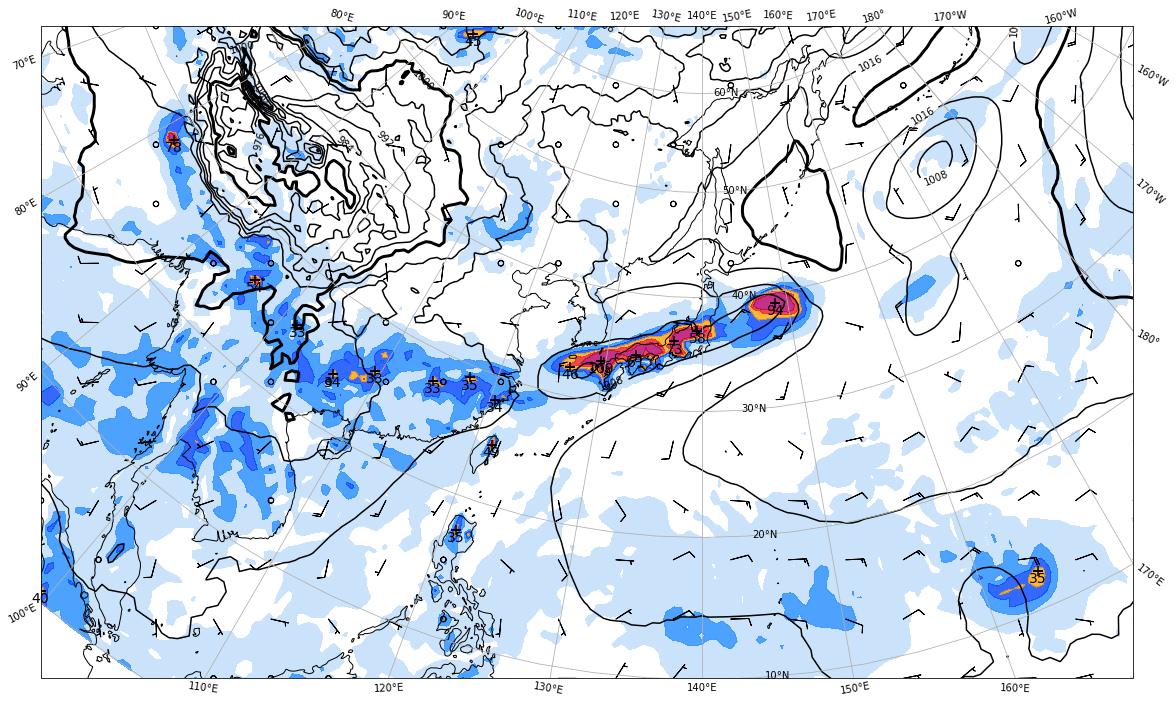

In [89]:
fig,ax=wmap.plot_surface_ps_wind_precip(ds_sfc)

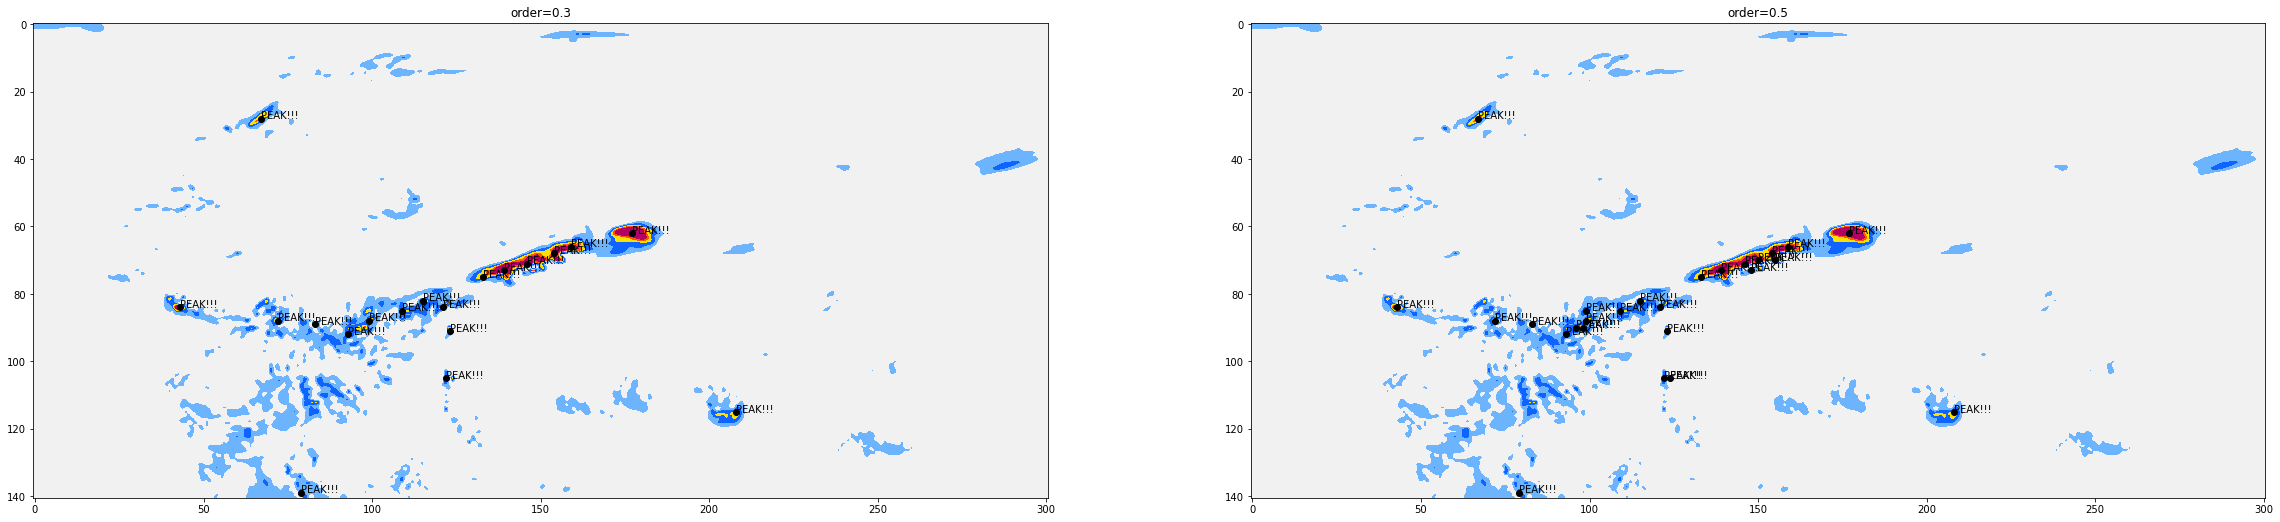

In [137]:
Fig = plt.figure(figsize=(40, 24))
Map1 = Fig.add_subplot(121)
Map2 = Fig.add_subplot(122)

Map1.set_title('order=0.3')
Map1.imshow(precip, interpolation='spline36', cmap=cmap,norm=norm)
prev_x,prev_y=None,None
peak_list=[]
for idx,(x,y) in enumerate(zip(df_peak["x"],df_peak["y"])):
    if (prev_x is not None ):
        r=np.sqrt((x-prev_x)**2 + (y-prev_y)**2)
        if r < 5:
            continue
    prev_x,prev_y=x,y
    peak_list.append(idx)

peak_list2=[]    
df_peak_sort=df_peak.loc[peak_list].sort_values("x")
prev_x,prev_y=None,None
for (idx,x,y) in zip(df_peak_sort.index,df_peak_sort["x"],df_peak_sort["y"]):
    if (prev_x is not None):
        r=np.sqrt((x-prev_x)**2 + (y-prev_y)**2)
        if r < 5:
            continue
    prev_x,prev_y=x,y
    peak_list2.append(idx)
for x,y in zip(df_peak_sort.loc[peak_list2,"x"], df_peak_sort.loc[peak_list2,"y"]):
    Map1.scatter(x, y, color='black')
    Map1.text(x, y, 'PEAK!!!')
    
    
Map2.set_title('order=0.5')
Map2.imshow(precip, interpolation='spline36', cmap=cmap,norm=norm)
for x,y in zip(maxid1[1][:],maxid1[0][:]):
    Map2.scatter(x, y, color='black')
    Map2.text(x, y, 'PEAK!!!')

In [112]:
norm=custom_colormap.get_norm([0.1,10,20,30,40.,50])